# water-shed-analysis

This notebook includes some exploratory analysis of applying pysheds watershed analysis library to newly generated digital elevation models from the OS Terrain 50 dataset.

## Import Data and Plot Elevation

c:\Users\PC\anaconda3\envs\watershed\Lib\site-packages\pysheds\io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
c:\Users\PC\anaconda3\envs\watershed\Lib\site-packages\pysheds\io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
C:\Users\PC\AppData\Local\Temp\ipykernel_19740\1116266857.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


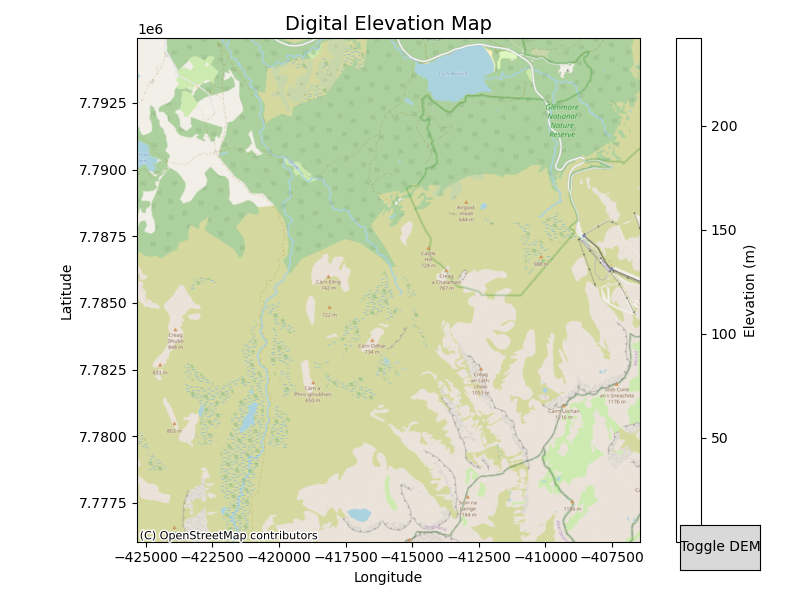

In [57]:
%matplotlib notebook
%matplotlib widget

from pysheds.grid import Grid
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib import colors
from matplotlib.widgets import Button

# Read the elevation raster using pysheds
grid = Grid.from_raster('morlich-dem.tif')
dem = grid.read_raster('morlich-dem.tif')

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

# Plot the DEM with reduced opacity
dem_image = ax.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1, alpha=0)
plt.colorbar(dem_image, label='Elevation (m)')
ax.set_title('Digital Elevation Map', size=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add OpenStreetMap Basemap using contextily
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik)

# Ensure the basemap aligns with the extent of the DEM
ax.set_xlim(grid.extent[0], grid.extent[1])  # Longitude extent
ax.set_ylim(grid.extent[2], grid.extent[3])  # Latitude extent

# Function to toggle between DEM and OSM
def toggle(event):
    # Toggle DEM visibility
    if dem_image.get_alpha() == 0.25:
        dem_image.set_alpha(1.0)  # Make DEM fully visible
    else:
        dem_image.set_alpha(0.25)  # Make DEM partially transparent

    # Redraw the plot to apply changes
    plt.draw()

# Add a button to toggle the layers
ax_toggle = plt.axes([0.85, 0.05, 0.1, 0.075])  # Position of the button
button = Button(ax_toggle, 'Toggle DEM')

# Link the button to the toggle function
button.on_clicked(toggle)

# Show the plot with the button
plt.tight_layout()
plt.show()


## Condition the elevation data

In [46]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

## Elevation to flow direction

In [47]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

## Plot elevation to flow direction

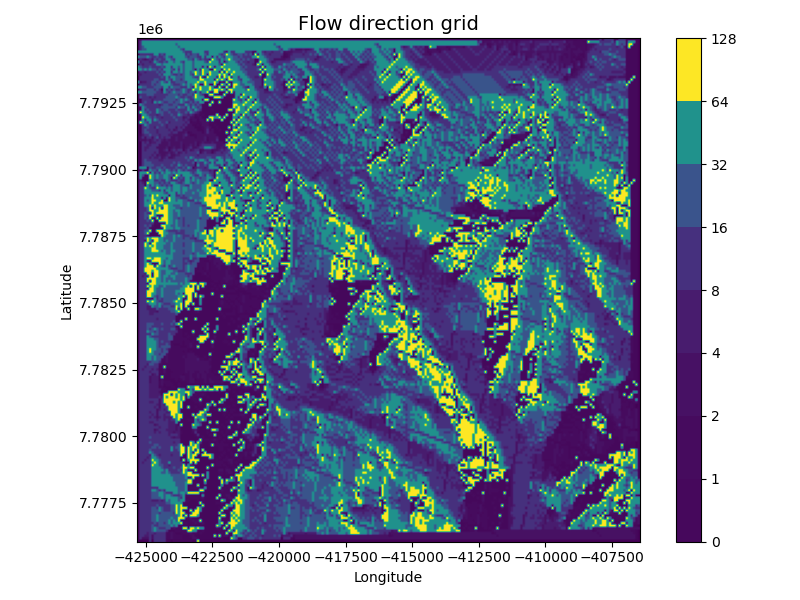

In [48]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

## Compute accumulation from flow direction

In [49]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

## Plot accumulation from flow direction

C:\Users\PC\AppData\Local\Temp\ipykernel_19740\994662952.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


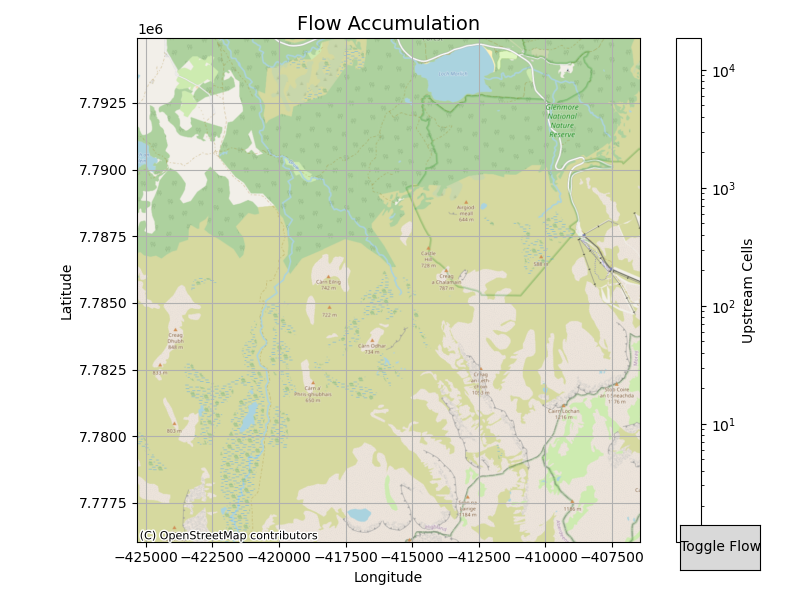

C:\Users\PC\AppData\Local\Temp\ipykernel_19740\994662952.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [60]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
flow_im = ax.imshow(acc, extent=grid.extent, zorder=2, alpha=0,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(flow_im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add OpenStreetMap Basemap using contextily
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik)

# Ensure the basemap aligns with the extent of the DEM
ax.set_xlim(grid.extent[0], grid.extent[1])  # Longitude extent
ax.set_ylim(grid.extent[2], grid.extent[3])  # Latitude extent

# Function to toggle between DEM and OSM
def toggle(event):
    # Toggle DEM visibility
    if flow_im.get_alpha() == 0.25:
        flow_im.set_alpha(1.0)  # Make DEM fully visible
    else:
        flow_im.set_alpha(0.25)  # Make DEM partially transparent

    # Redraw the plot to apply changes
    plt.draw()

# Add a button to toggle the layers
ax_toggle = plt.axes([0.85, 0.05, 0.1, 0.075])  # Position of the button
button = Button(ax_toggle, 'Toggle Flow')

# Link the button to the toggle function
button.on_clicked(toggle)

# Show the plot with the button
plt.tight_layout()
plt.show()
plt.tight_layout()

## Delineate catchment from flow direction

In [51]:
# Delineate a catchment
# ---------------------
# Specify pour point
x, y = 217295,754163

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)
print(grid.polygonize())

<generator object shapes at 0x000001879AC60240>


## Plot the catchment

Text(0.5, 1.0, 'Delineated Catchment')

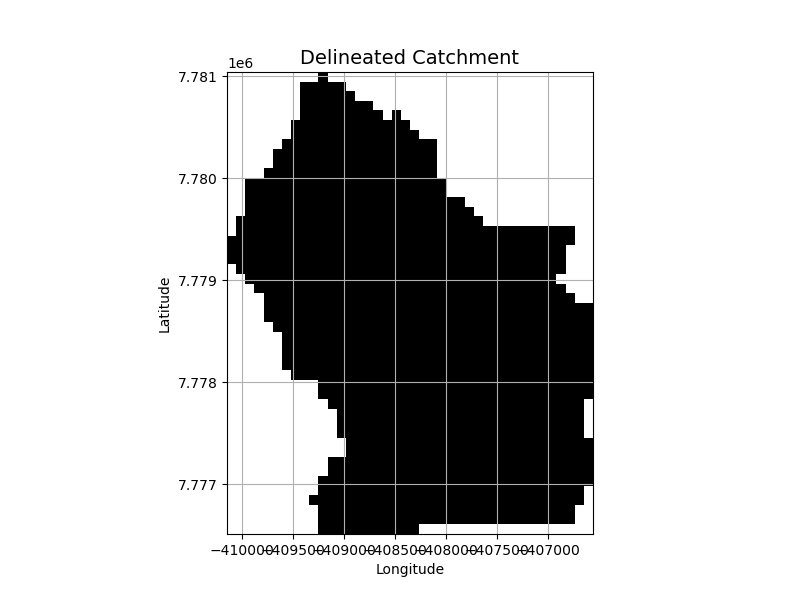

In [52]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

## Extract the river network

In [53]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

## Plot the river network

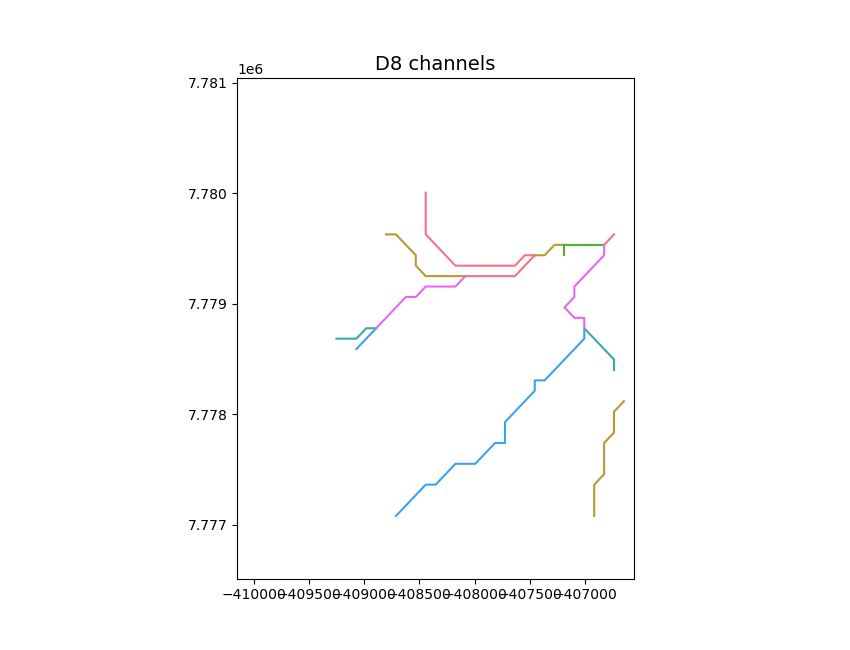

In [54]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

## Compute flow distance from flow direction

In [55]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

## Plot flow distance from flow direction

Text(0.5, 1.0, 'Flow Distance')

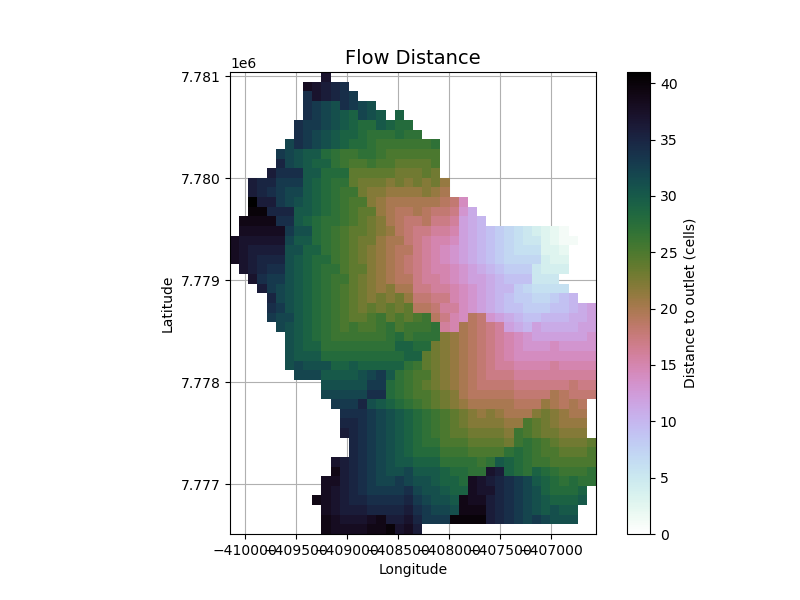

In [56]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)